# Convolutional Neural Networks - Lab 2

<table class="tfo-notebook-buttons" align="left">
 <td>
 <a target="_blank" href="https://colab.research.google.com/drive/14lRNogX_yUQI9abkUwZBFqvWiqNcVGf3?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
 </td>
 <td>
 <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/blob/main/CNN/cnn_lab2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
 </td>
</table>
<br>
<br>
<br>

---
Module Coordinator: Ekta Gavas

Email: ekta.gavas@research.iiit.ac.in


## Description
---
In this lab exercise, we will understand how stacking smaller filters is beneficial. Further, we will study a simple image classification problem using CNNs. We will implement a basic CNN model for classifying grayscale MNIST images and train it end-to-end and evaluate our model on test data.

## Starter Code
---
To make your task easier, we provide you the starter code to perform the lab exercises. It is expected that you should try to understand what the code does and analyze the output. We will be using Pytorch framework for the implementation of this lab. The training hyperparameters that are used in the code may not be the best to minimize training time according to lab scope. 

## Stacking convolution layers vertically

Normally, stack of small filter convolutions are preferred compared to large filter convolutions. Suppose that you stack two 3x3 CONV layers on top of each other (with non-linearities in between, of course). In this arrangement, each neuron on the first CONV layer has a 3x3 view of the input volume. A neuron on the second CONV layer has a 3x3 view of the first CONV layer, and hence by extension a 5x5 view of the input volume. Intuitively, stacking CONV layers with tiny filters as opposed to having one CONV layer with big filters allows us to express more powerful features of the input, and with fewer parameters.

<img src='https://images.storychief.com/account_16771/7_e077bca1064609d5e4390df9f6de7384_1600.png' height=300px width=700px/>

Image reference:https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel

In [ ]:
# Import packages
import cv2
import numpy as np
import matplotlib.pyplot as plt

Now, we will see the result of convolving a 5x5 edge filter on the image in one case and convolving two 3x3 edge filters in one after the other.
Below is the same function to apply given kernel to image, which we implemented at first in the previous lab.

In [ ]:
def apply_filter(img, filter):
  height, width = img.shape
  filter_size = filter.shape

  output = np.empty(0)

  # Move the filter over entire image and store the result in output
  for i in range(0, height - filter_size[1] + 1):
    for j in range(0, width - filter_size[0] + 1):
      # Matrix multiplication for a single patch of image and filter
      output = np.append(output, np.sum(np.multiply(img[i:i+filter_size[0], j:j+filter_size[1]], filter)))
  
  # Calculate the output shape of the resultant image
  output_shape = (height - (filter_size[1]-1)), (width - (filter_size[0]-1))

  # Return the reshaped image
  return output.reshape(output_shape)

In [ ]:
# Get the sample image
!curl -L -o 'lotus.jpg' 'https://drive.google.com/uc?export=download&id=1gQSQlrUws22KLRUacXwvN1G8FtIyhfGt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    527      0 --:--:-- --:--:-- --:--:--   527
100  2815  100  2815    0     0   2714      0  0:00:01  0:00:01 --:--:--  2714


Now, let's apply the convolutions to image

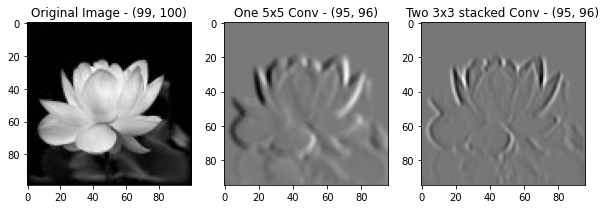

In [ ]:
# Read the image with opencv, 0 stands for 'grayscale'
image = cv2.imread('lotus.jpg', 0)

# 5 x 5 Vertical edge filter
filter5 = np.array([[1, 1, 0,-1, -1],
                   [1, 1, 0,-1, -1],
                   [1, 1, 0,-1, -1],
                   [1, 1, 0,-1, -1],
                   [1, 1, 0,-1, -1]])

# Apply the 5x5 filter to image
output1 = apply_filter(image, filter5)


filter3 = np.array([[1,0,-1],
                   [1,0,-1],
                   [1,0,-1]])

# Apply 3x3 filter to image and again, apply the same filter to the output
output2 = apply_filter(image, filter3)
output2 = apply_filter(output2, filter3)


# Plot results
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(1,3,1)
ax.imshow(image, cmap='gray')
ax.set_title('Original Image - '+str(image.shape))

ax = fig.add_subplot(1,3,2)
ax.imshow(output1, cmap='gray')
ax.set_title('One 5x5 Conv - '+str(output1.shape))

ax = fig.add_subplot(1,3,3)
ax.imshow(output2, cmap='gray')
ax.set_title('Two 3x3 stacked Conv - '+str(output2.shape))
plt.show()

As you can see, the output image size in both the cases is the same and the edges in the second case are detected more appropriately. Now, let's also calculate the number of parameters in both cases. The parameters are less in the stack of filters.

In [ ]:
print('Number of parameters in 5x5 Conv: ', str(5*5))
print('Number of parameters in equivalent 3x3 stacked Conv: ', str((3*3) * 2)) #stack of 2 filters

Number of parameters in 5x5 Conv:  25
Number of parameters in equivalent 3x3 stacked Conv:  18


## MNIST Digit Classification

<img src='https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png' />

Image reference: https://miro.medium.com/max/1872/1*SGPGG7oeSvVlV5sOSQ2iZw.png

We will be implementing a CNN model which can predict the digit, given a grayscale image. The architecture of model is given in the above image.

**We will do the following steps in order:**
1.   Load and visualize MNIST training and test datasets using torchvision
2.   Define the CNN model
3.   Define a loss function and optimizer
4.   Train the network on the training data
5.   Evaluate the network on the test data

In [ ]:
# Import packages
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Set seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

#### Load MNIST data
We will use the [MNIST dataset](https://pytorch.org/vision/stable/datasets.html#mnist) from torchvision Pytorch and setup the train and test dataloaders.

In [ ]:
batch_size_train = 128
batch_size_test = 128

# Images in torchvision datasets are PIL Images in range [0,1] so we need
# 'ToTensor' transform to convert them into tensors
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


#### Understand the dataset
Let us now visualize the dataset in terms of number of samples, classes etc.

In [ ]:
print('Training data shape : ', train_data.data.shape, train_data.targets.shape)
print('Testing data shape : ', test_data.data.shape, test_data.targets.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_data.targets.numpy())
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Training data shape :  torch.Size([60000, 28, 28]) torch.Size([60000])
Testing data shape :  torch.Size([10000, 28, 28]) torch.Size([10000])
Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


In [ ]:
# Helper function to plot data
def plot_data(images, labels, classes=None):
  figure = plt.figure(figsize=(9, 4))
  cols, rows = 5, 2
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(images), size=(1,)).item()
      img, label = images[sample_idx], labels[sample_idx]
      figure.add_subplot(rows, cols, i)
      if classes is not None:
        label = classes[label]
      plt.title('Label:' +str(label))
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

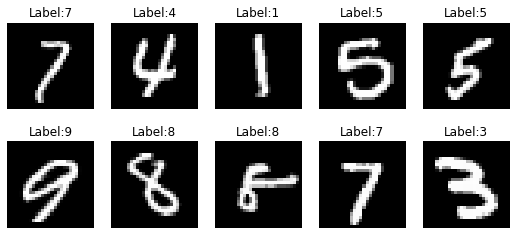

In [ ]:
plot_data(train_data.data, train_data.targets.numpy())

#### Define the model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)                          
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layer
        self.fc = nn.Linear(64 * 7 * 7, 128)
        # output layer 10 classes
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x) #activation
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        # flatten the output for FC layer
        x = x.view(x.size(0), -1)       
        x = self.fc(x)
        output = self.out(x)
        return output

In [ ]:
# Build the model object and put on the device
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=3136, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)


#### Define Loss function

In [ ]:
# Cross Entropy loss for multi-class classification
loss_func = nn.CrossEntropyLoss()   

#### Define optimizer

In [ ]:
# Basic SGD optimizer with 0.01 learning rate
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#### Train the model

Helper function for training/testing

In [ ]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           

      # Put data on devices
      images = images.to(device)
      labels = labels.to(device)

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

In [ ]:
def test(model, test_loader):
  # Eval mode
  model.eval()
  test_acc = 0
  correct = 0
  for i, (images, labels) in enumerate(test_loader):
    # Deactivate autograd engine (don't compute grads since we're not training)
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      output = model(images)

      # Calculate number of correct predictions
      _, preds = torch.max(output, dim=1)
      correct += (preds == labels).sum()

  test_acc = correct / len(test_loader.dataset)
  print('Test Accuracy: {:.4f}'.format(test_acc*100))

  # Plot the images with predicted labels
  plot_data(images.data.cpu().numpy(), preds.data.cpu().numpy(), test_loader.dataset.classes)

Start training

In [ ]:
num_epochs = 10  # iterations
train_losses, train_acc = train(num_epochs, model, train_loader, loss_func, optimizer)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/10, Loss: 0.0128, Accuracy: 56.6733
Epoch 2/10, Loss: 0.0032, Accuracy: 87.7717
Epoch 3/10, Loss: 0.0025, Accuracy: 90.4100
Epoch 4/10, Loss: 0.0021, Accuracy: 91.8133
Epoch 5/10, Loss: 0.0018, Accuracy: 93.0117
Epoch 6/10, Loss: 0.0016, Accuracy: 94.1067
Epoch 7/10, Loss: 0.0013, Accuracy: 94.9567
Epoch 8/10, Loss: 0.0012, Accuracy: 95.6083
Epoch 9/10, Loss: 0.0010, Accuracy: 96.0767
Epoch 10/10, Loss: 0.0009, Accuracy: 96.4000


Plot training plots

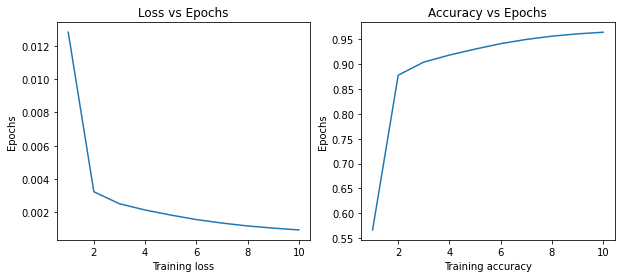

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

#### Evaluate the model

Test Accuracy: 96.9200


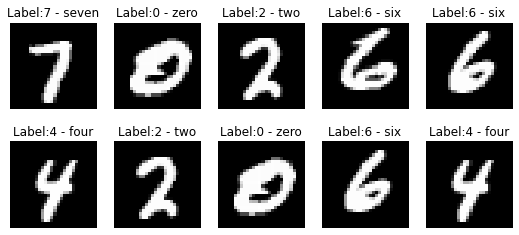

In [ ]:
# Evaluate the model on testing data and plot predictions
test(model, test_loader)

## Exercises

Q 1: What is the ratio of parameters in single 5 x 5 kernel and equivalent stacked 3 x 3 kernels? Consider number of channels in input and output channels as C.

Q 2: How can you replace 7 x 7 convolution kernel using only 3 x 3 kernels? What would be ratio of parameters in this case? Consider number of channels in input and output channels as C.

Answer: 

Q 3: Can you guess what can happen if the output of each convolution layer is not Relu activated? In other sense, can you state the importance of Relu activation at each layer?
(Hint: You can comment those two lines in the forward function and check if your guess was right!)

Answer:

Q 4: Calculate the layerwise number of parameters in the MNIST CNN network. Ignore the bias parameters. Which layer does not have any learnable parameters?

Answer:

Q 5: For the below image, what is the ratio of the number of parameters if we use a fully connected layer compared to a convolutional layer?

<img src='https://drive.google.com/uc?id=1Chi7puquqg_3hyVATDeLgMBZIzFv79E2' height=200/>

### Bonus Question
Perform image classification for Fashion MNIST dataset from Pytorch. You can copy paste the code in below cells for the data loading and visualization, model and training from above. You just need to replace the dataset class 'MNIST' with '[FashionMNIST](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)' and keep the hyperparameters the same. Comment on the model performance. Can you improve it further?

Answer:

## References and Additional Resources:


*   [About Convolutional Layer and Convolution Kernel](https://www.sicara.ai/blog/2019-10-31-convolutional-layer-convolution-kernel)
*   [MNIST digit classification in Pytorch](https://nextjournal.com/gkoehler/pytorch-mnist)
*   [CNNs - (Advanced)](https://cs231n.github.io/convolutional-networks/)
*   [Torchvision Datasets](https://pytorch.org/vision/stable/datasets.html)

